In [1]:
'''
Image Segmentation using Mask and RGB
Task : Given an input RGB image, predict the mask of the concerned object.
Input: Given an RGB input (Height, Width, 3vals: R,G,B) - each pixel has 3 values corresponding to a single pixel
Output : Mask(R, G, 1)
'''

'\nImage Segmentation using Mask and RGB\nTask : Given an input RGB image, predict the mask of the concerned object.\nInput: Given an RGB input (Height, Width, 3vals: R,G,B) - each pixel has 3 values corresponding to a single pixel\nOutput : Mask(R, G, 1)\n'

### Data Exploration

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2 as cv2

In [36]:
from google.colab.patches import cv2_imshow

In [3]:
'''
Dataset : Image segementation masks 3 classses
Generic info: 37 diff catregories, ~200 samples from each class
'''

##tfds.list_builders()
## ds = tfds.load('oxford_iiit_pet', split = 'train', shuffle_files=True)
dataset = tfds.load('oxford_iiit_pet', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTYVWBW/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTYVWBW/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
print(dataset) ## printing the datastructure to see what kind of dataset is printed
print(dataset.keys()) ## printing what was the datastructure to be printed


{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}
dict_keys(['train', 'test'])


In [5]:
##lets iterate over a single record from the dataset and understand the kind of parameter and points present in the datset
## so lets extract 1 single instance from the training dataset
ds = dataset['train'].take(1)
for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  mask = example['segmentation_mask']
  print(label) ## tells us about the field of data present in the dataset record in the dataset
  print(image.shape) ## this tells us about the dimensionality of a single pricute
  print(mask.shape)
  print(example['species'])
  print('Image values:', tf.reduce_min(image), tf.reduce_max(image))
  flattened_tensor = tf.reshape(mask, [-1])
  print('Mask values:', tf.unique(flattened_tensor))  # this part gives the details on the mask part of the instance datastructure

['file_name', 'image', 'label', 'segmentation_mask', 'species']
tf.Tensor(21, shape=(), dtype=int64)
(333, 500, 3)
(333, 500, 1)
tf.Tensor(1, shape=(), dtype=int64)
Image values: tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)
Mask values: Unique(y=<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([2, 3, 1], dtype=uint8)>, idx=<tf.Tensor: shape=(166500,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


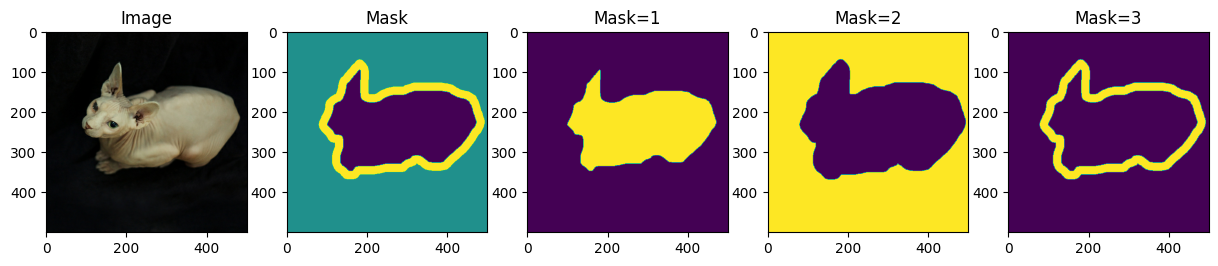

In [6]:
## from the above output of the segmentation mask we see that tensorflow is using 3 labels in the images, to perform segmentation

# Displaying the dataset
for example in ds:
  image = example["image"]
  mask = example["segmentation_mask"]

  plt.figure(figsize=(15, 15))
  plt.subplot(1, 5, 1)
  plt.title('Image')
  plt.imshow(image)

  plt.subplot(1, 5, 2)
  plt.title('Mask')
  plt.imshow(mask) ## entire segmentation_mask

  # Plotting the individual masks from the labels (2,3,1) we see which label indicated what
  plt.subplot(1, 5, 3)
  plt.title('Mask=1')
  plt.imshow(mask==1) ## segmentation of the foreground

  plt.subplot(1, 5, 4)
  plt.title('Mask=2')
  plt.imshow(mask==2) ## segmentation of the background

  plt.subplot(1, 5, 5)
  plt.title('Mask=3')
  plt.imshow(mask==3) ## segmentation of the ambigious region (i.e the border beteween background and foreground)

Now from the documentation and image segementation annotaion in the official documentation we can clearly see that the output we can clearly see that the the image segmentation has been divided into the 3 types:
1 : Foreground
2 : Background
3 : Ambigious region

In [7]:
dataset['train']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

### Data Pre-Processing


In [8]:
## Since the image and mask sizes are varying across the dataset, we have to standardize before pouyring it in the  model
# 1. Standardization of the dataset values present inside the data
# 2. Train + Test split the dataset for better


In [9]:
def normalize_img(ds):
  image = ds["image"]
  mask = ds["segmentation_mask"]
  ## Now we have to standardize the image size and also check for the interpolation method for image_segmentation and lebelling
  image = tf.image.resize(image, [128, 128])
  ## since in masking and image segmentation we have particular labels having particular meaning associated to it, we shouldnt loose it
  mask = tf.image.resize(mask, [128, 128], method = 'nearest') ## so we change the interpolation method

  """Normalizes images: `uint8` -> `float32`."""
  ## since the TFDS provide images of type tf.uint8, while the model expects tf.float32. Therefore, you need to normalize images.
  ## image normalization
  image = tf.cast(image, tf.float32)/255.0
  mask = tf.cast(mask-1, tf.float32)## since typically classification problems are 0 indexed we should make the mask values, as mask-1
   ## as the segmentation_mask values are 1,2,3
  return image, mask


In [10]:
ds_train = dataset['train'].map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache() ## caching stores the data, images in a cache format before flusing out completely to save time during runtime

ds_train = ds_train.shuffle(1000)

ds_train = ds_train.batch(128) ## the data is fed in batches to the model

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)## getting the next batch ready before the current batch is already passed

In [11]:
## Now we have to do all those things and procedures with the test dataset as well, whcih we did with training dataset

ds_test = dataset['test'].map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)

ds_test = ds_test.cache()

ds_test = ds_test.batch(128)

ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [12]:
print(ds_train)

'''
Post Processing, what we have is:-
1. All images in (128 X 128) size specifically
2. all the labelling and segmentation_masking is 0-indexed
3.
'''

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


'\nPost Processing, what we have is:-\n1. All images in (128 X 128) size specifically\n2. all the labelling and segmentation_masking is 0-indexed\n3.\n'

### Model Building

Sequential Model Building is the most basic and fundamental and simplistic way of buidling a Neural network architecture simply by stacking 1 layer of neurons over the other!!

In [13]:
# Sequential Layering based modelling
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1))

model.build((None, 16))

In [14]:
model.summary()
## Here each layer is a tranformation which converts the input to output

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Dense 5 gets it input as the output from  the dense 4
### what takes place is that the Dense 4 network outputs in a shape of 8 features and it uses 136 parameters for that


In [15]:
## Now  if we want to find out the length of the model weights
print(len(model.weights))

4


In [16]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.Input(shape=(16,)))
model1.add(tf.keras.layers.Dense(4))
model1.add(tf.keras.layers.Dense(1))

In [17]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
## Since input is already included in the layers we dont have to seperately build the model
print(len(model1.weights))

4


### Functional API based Modelling
#### Allows a greater degree of customization in the neural netwrok with selective input feature/ parameter selection and activation function selection

In [19]:
## Functional API based model building
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs) ## Here we are feeding the previous formed inputs as parameter
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x) ## here we also have the option of passing selected paramters as input
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 16        
                                                                 
 dense_5 (Dense)             (None, 5)                 25        
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Now basically we are going to use some more powerful model in Deep Learning for more robust outcomes, Unet - U-Net is a convolutional neural network that was developed for biomedical image segmentation.

### It basically succesively convolutes and breaks down the image from its original resolution to smaller fragments and again Decodes back to original resolution.

### That structure resembles a U structure hence Unet structure

In [21]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

### So, since the MobileNet part is responsible for encoding and the classification of the image segmentation and for the decoding part required for the labelling and segmentation we need to decode it.

In [22]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [23]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-6hxpmgvu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-6hxpmgvu
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=5a796f32d972f217c173025d6f54584676d988206f7e9a9c0258e2fb5d2c9c9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6tmuyj9r/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [24]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
## since in the segmentation_masking/ labelling we have 3 areas that we have to break the image down,
## we have 3 output parameters for the Unet model
model = unet_model(3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 64, 64, 96),         1841984   ['input_4[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

In [26]:
# Image Segm: Per-pixel classification

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

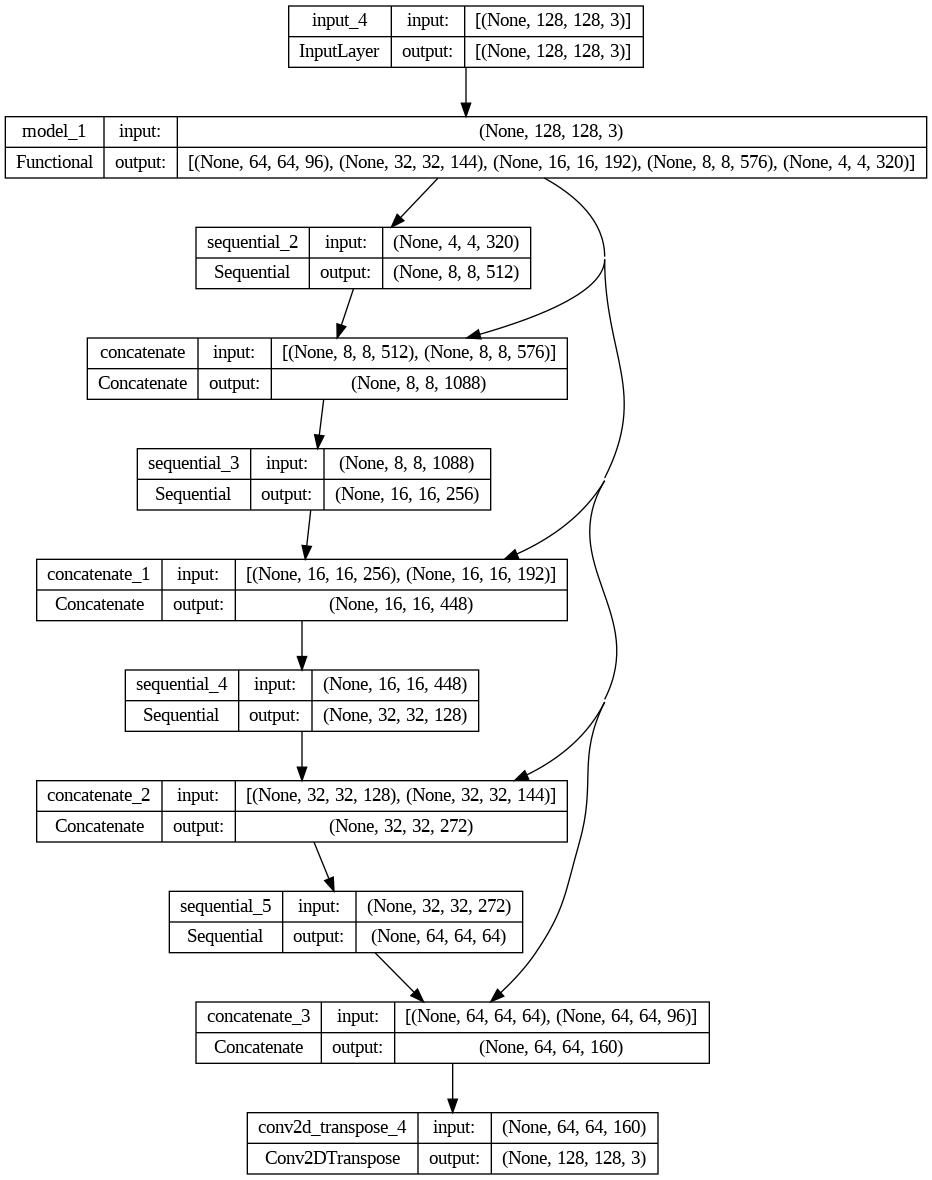

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
history = model.fit(
    ds_train,
    epochs=12,
    validation_data=ds_test,
)

Epoch 1/12
29/29 [==============================] - 56s 1s/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.9484 - val_sparse_categorical_accuracy: 0.7105
Epoch 2/12
29/29 [==============================] - 9s 329ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8605
Epoch 3/12
29/29 [==============================] - 10s 334ms/step - loss: 0.2933 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.8832
Epoch 4/12
29/29 [==============================] - 10s 335ms/step - loss: 0.2692 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.3082 - val_sparse_categorical_accuracy: 0.8841
Epoch 5/12
29/29 [==============================] - 10s 337ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.9011 - val_loss: 0.2991 - val_sparse_categorical_accuracy: 0.8862
Epoch 6/12
29/29 [==============================] - 10s 345ms/step - loss: 0.2439 - sparse_categori

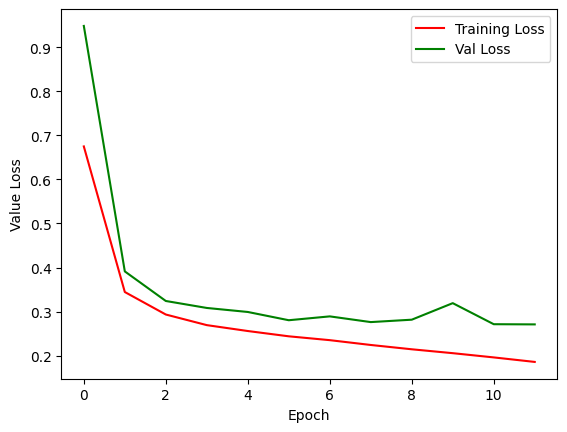

In [29]:
## jUst to visualize the val_loss and how and if it decreased over a period of epochs/ iterations we can visualize it
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label = "Training Loss")
plt.plot(history.epoch, val_loss, 'g', label = "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Value Loss")
plt.legend()
plt.show()

### Model Evaluation

In [30]:
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


4/4 [==============================] - 3s 21ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============

<ipython-input-31-ac42b2fa21f2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 27ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 26ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
4/4 [==============================] - 0s 25ms/step
(128, 128, 128, 3) (128, 128, 128, 1) (128, 128, 128, 1)
3/3 [==============================] - 2s 803ms/step
(85, 128, 128, 3) (85, 128, 128, 1) (85, 128, 128, 1)


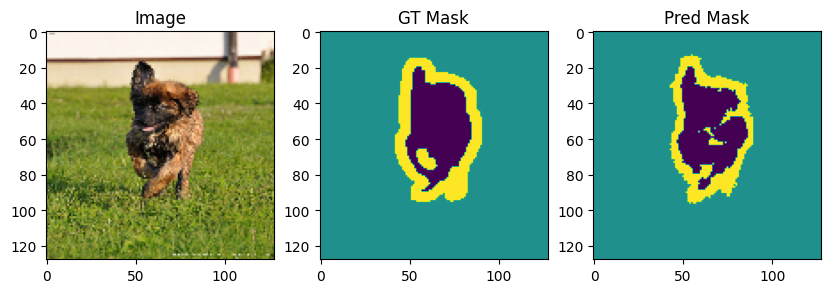

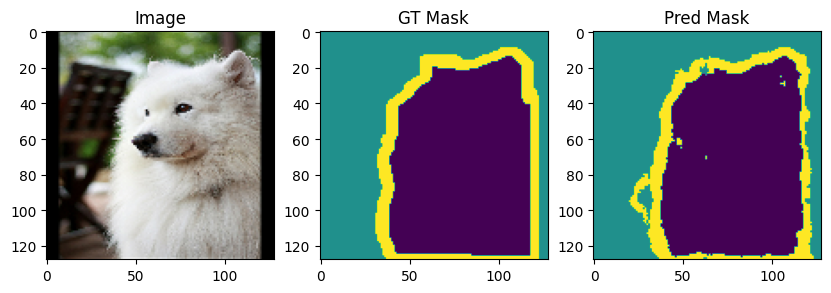

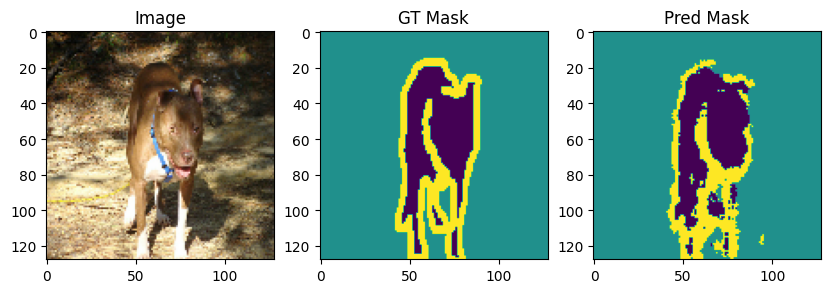

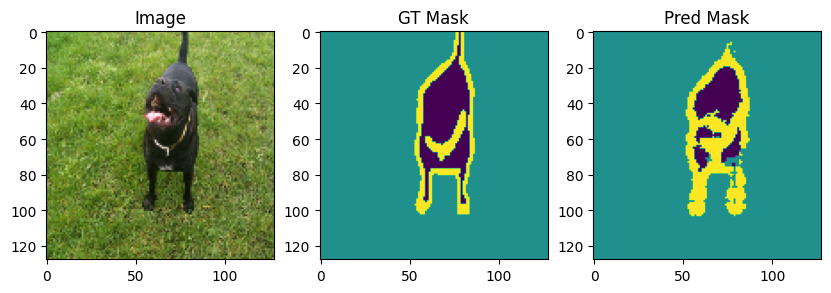

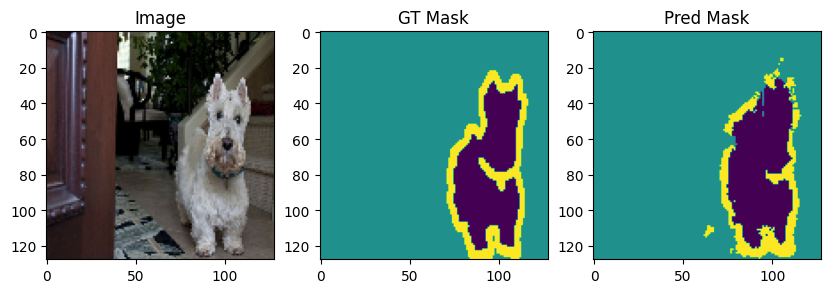

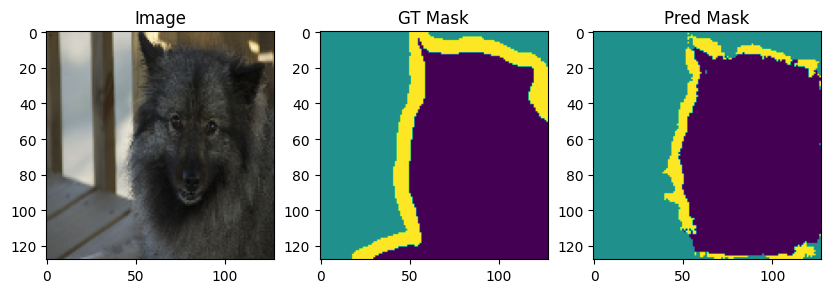

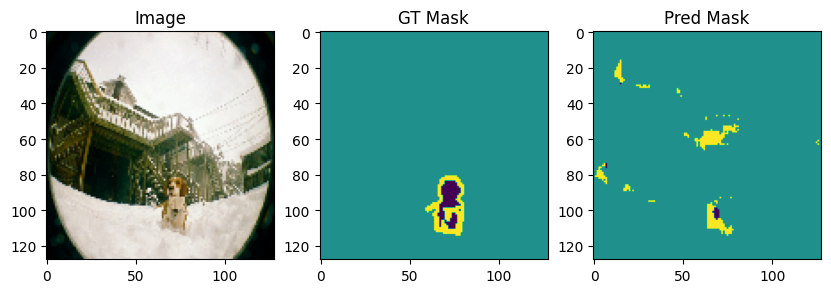

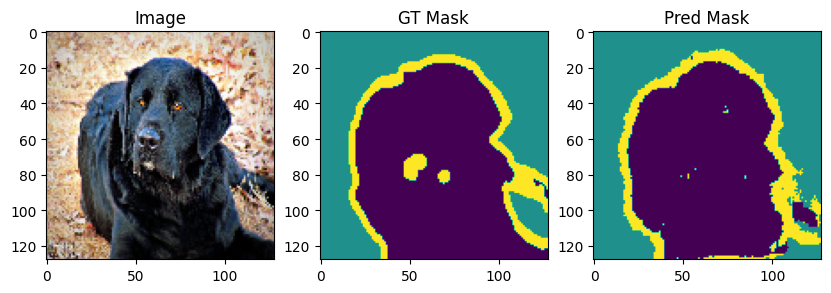

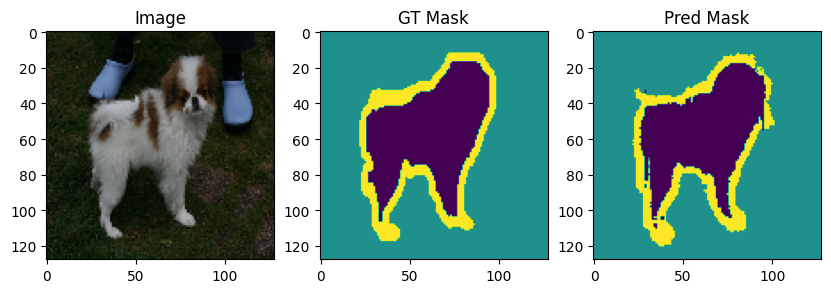

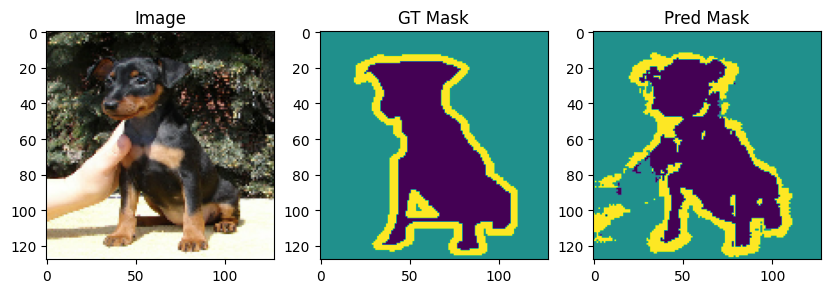

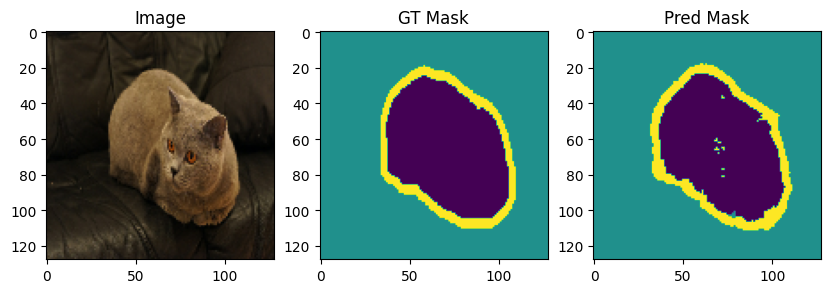

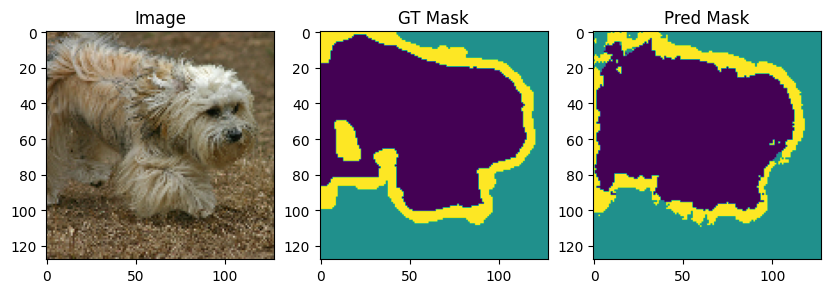

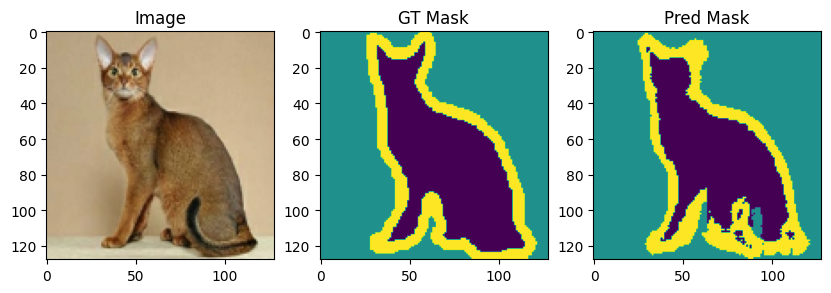

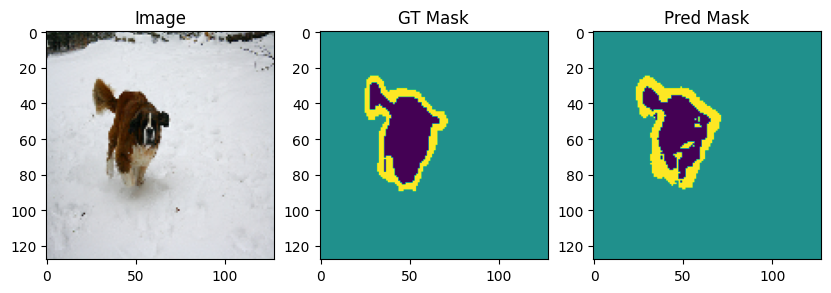

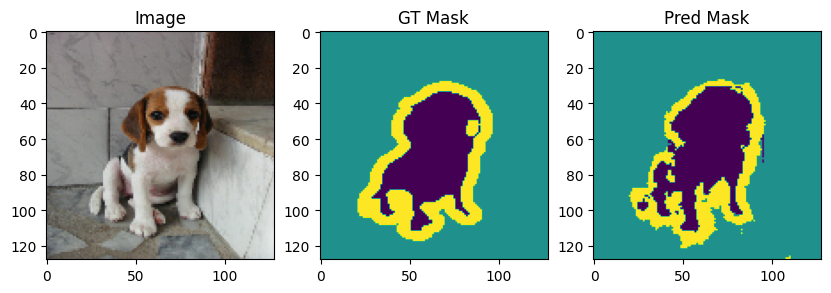

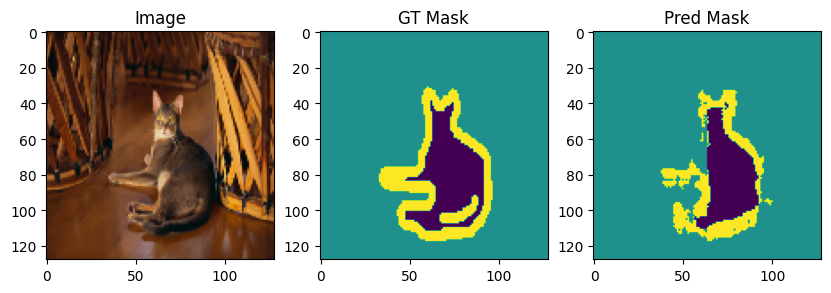

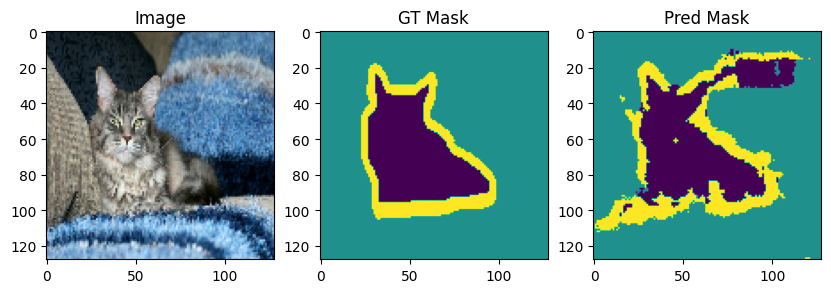

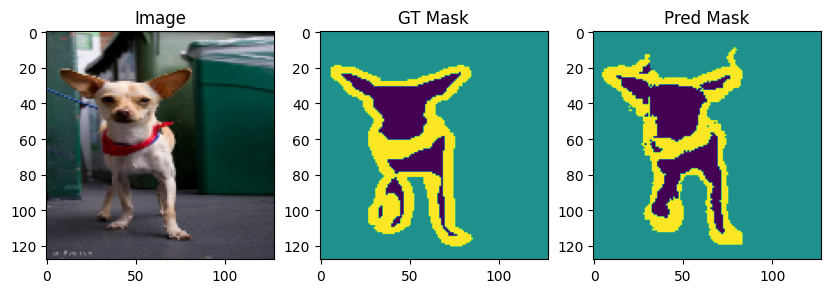

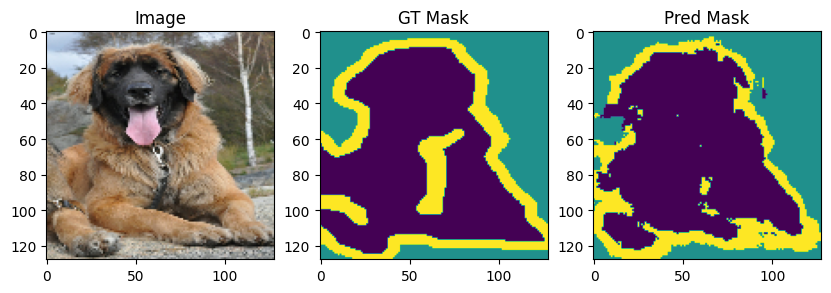

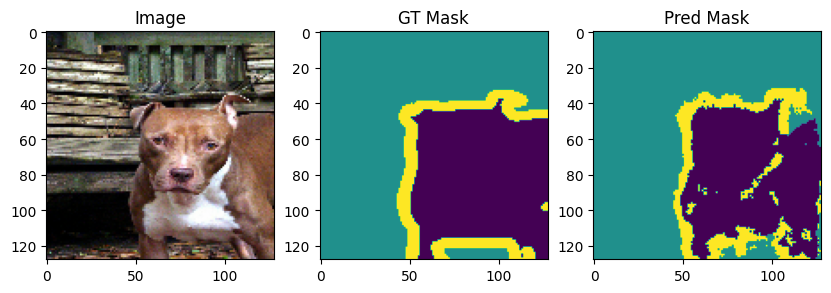

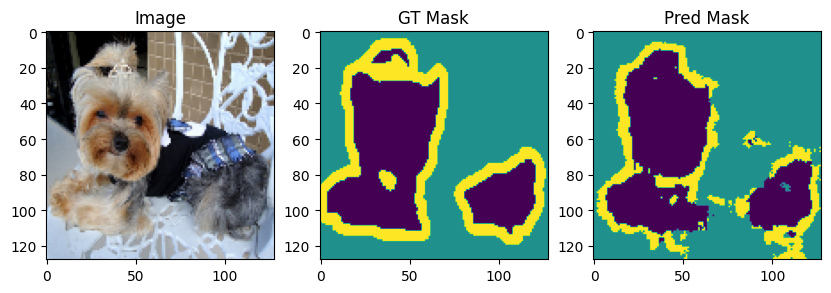

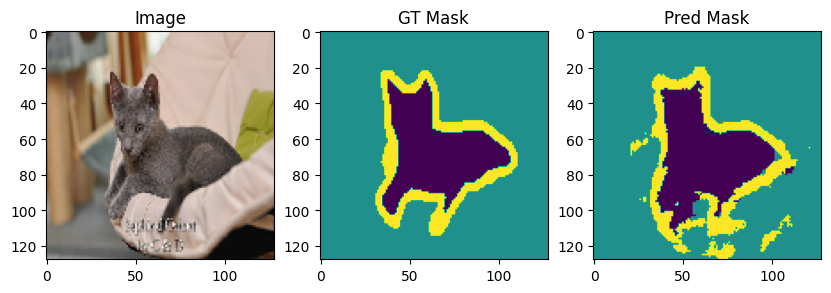

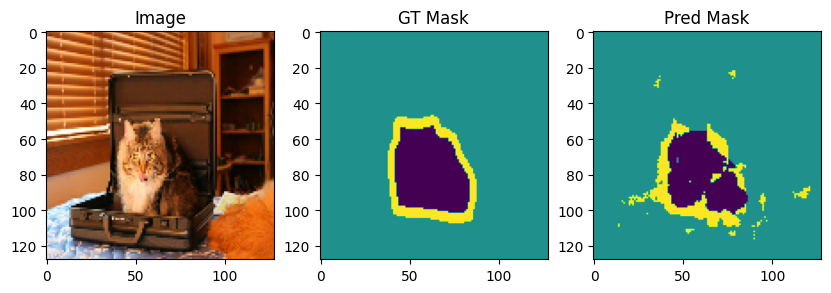

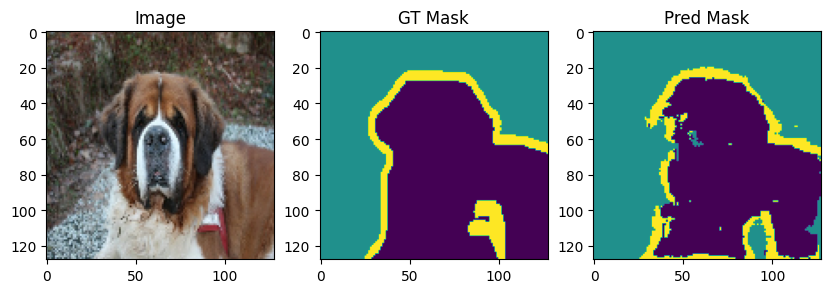

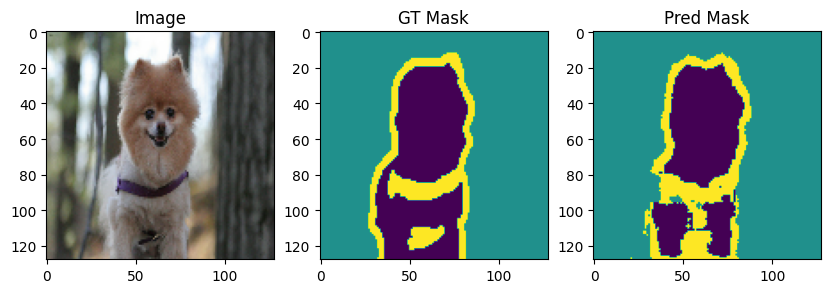

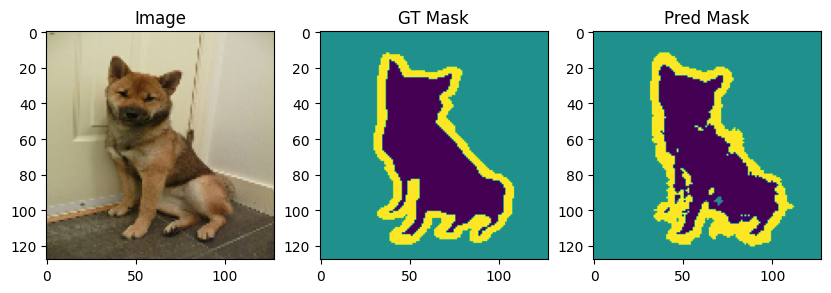

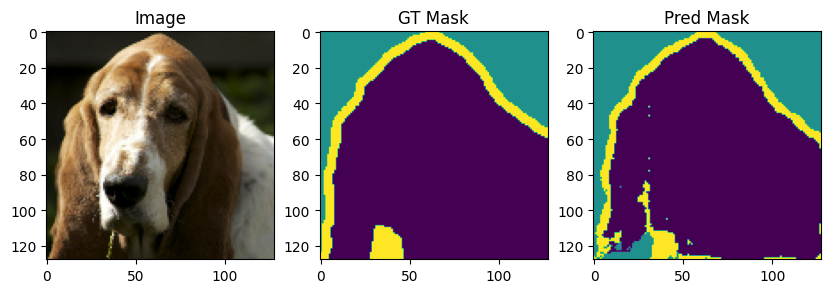

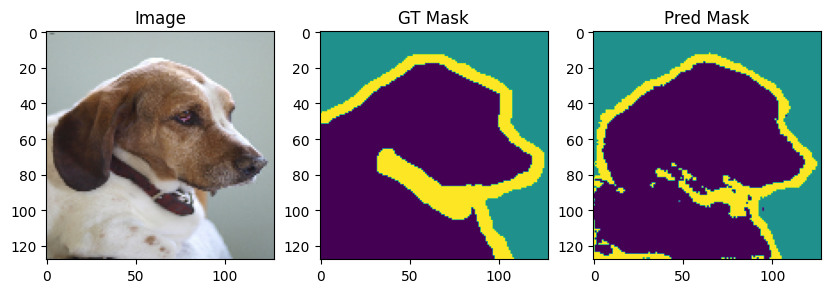

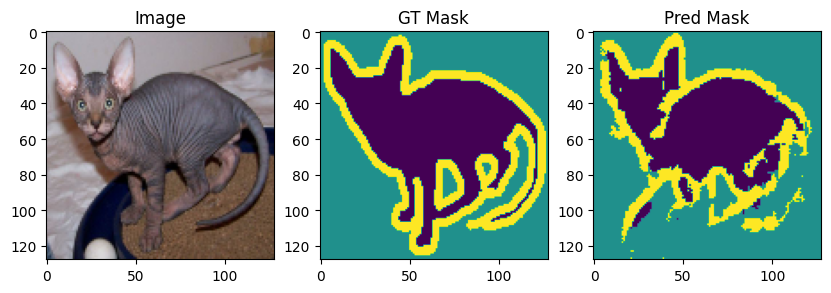

In [31]:
for (image, mask) in ds_test:
  pred_mask = model.predict(image)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  print(image.shape, mask.shape, pred_mask.shape)

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title('Image')
  plt.imshow(image[0])

  plt.subplot(1, 3, 2)
  plt.title('GT Mask')
  plt.imshow(mask[0])

  plt.subplot(1, 3, 3)
  plt.title('Pred Mask')
  plt.imshow(pred_mask[0])

## Otsu thresholding mehtod to segment the background and foreground of the image

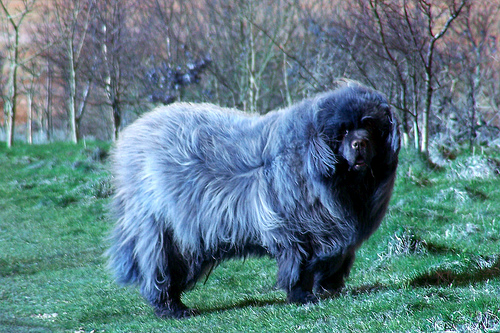

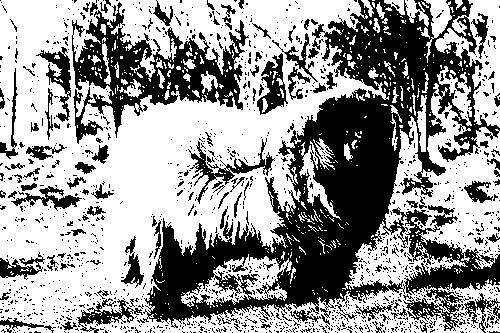

In [42]:
ds = dataset['train'].take(1)

for example in ds:
  sample_image = example['image']
# Extract the image from the example
image = sample_image

# Convert TensorFlow tensor to NumPy array
image_np = image.numpy()

# Convert the image to grayscale
img = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# Applying Otsu thresholding
ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the original and thresholded images
cv2_imshow(image_np)
cv2_imshow(thresh1)

# De-allocate any associated memory usage
cv2.waitKey(0)
cv2.destroyAllWindows()

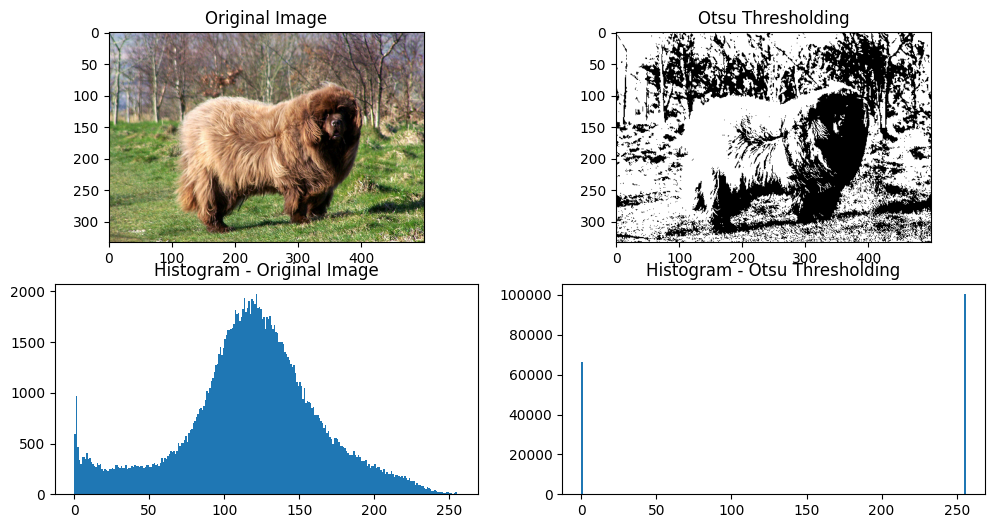

In [43]:
# Plot the histogram
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(thresh1, cmap='gray')
plt.title('Otsu Thresholding')

plt.subplot(2, 2, 3)
plt.hist(img.ravel(), 256, [0, 256])
plt.title('Histogram - Original Image')

plt.subplot(2, 2, 4)
plt.hist(thresh1.ravel(), 256, [0, 256])
plt.title('Histogram - Otsu Thresholding')

plt.show()

In [ ]:
""